In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import os.path as p
from pathlib import Path
import cv2 as cv
from tqdm import tqdm
from glob import glob

from scipy.stats import spearmanr, ttest_ind, tukey_hsd, f_oneway

In [2]:
def make_t_tests(df):
    def get_p(scores_1, scores_2):
        t, p = ttest_ind(scores_1, scores_2, equal_var=False, permutations=10000)
        return p
    
    def get_significance(p, correction):
        thresholds = [0.05, 0.01, 0.001]
        for i, threshold in enumerate(thresholds):
            if p < threshold * correction:
                return '*' * (i + 1)
        return ''

    columns = ['dsc', 'hd', 'assd']

    print('---- descriptives + ANOVA ----')
    print(f'Skin Type & N & DSC & HD & ASSD \\\\')
    print('\\hline')
    rows = ['Light', 'Medium', 'Dark', 'ANOVA']
    dsc_scores = [df['dsc'][df['nn_skin_type'] == 12], df['dsc'][df['nn_skin_type'] == 34], df['dsc'][df['nn_skin_type'] == 56]]
    hd_scores = [df['hd'][df['nn_skin_type'] == 12], df['hd'][df['nn_skin_type'] == 34], df['hd'][df['nn_skin_type'] == 56]]
    assd_scores = [df['assd'][df['nn_skin_type'] == 12], df['assd'][df['nn_skin_type'] == 34], df['assd'][df['nn_skin_type'] == 56]]

    for i, row in enumerate(rows[:-1]):
        print(f'{row} & {len(dsc_scores[i])} & {dsc_scores[i].mean():.3f} $\pm$ {dsc_scores[i].std():.3f} & {hd_scores[i].mean():.3f} $\pm$ {hd_scores[i].std():.3f} & {assd_scores[i].mean():.3f} $\pm$ {assd_scores[i].std():.3f} \\\\')


    anovas = []
    dsc_scores_log = [np.log(dsc_scores[0]), np.log(dsc_scores[1]), np.log(dsc_scores[2])]
    hd_scores_log = [np.log(hd_scores[0]), np.log(hd_scores[1]), np.log(hd_scores[2])]
    assd_scores_log = [np.log(assd_scores[0]), np.log(assd_scores[1]), np.log(assd_scores[2])]
    column_scores = [dsc_scores_log, hd_scores_log, assd_scores_log]

    for i, column_name in enumerate(columns):
        scores_dark = column_scores[i][2]
        scores_medium = column_scores[i][1]
        scores_light = column_scores[i][0]
        anova = f_oneway(scores_dark, scores_medium, scores_light)
        anovas.append(anova)

    print('\\\\[-1.4em]')
    print('\\hline \\\\[-1.4em]')
    print(f'ANOVA & - & \\makecell{{F = {anovas[0][0]:.3f} \\ p = {anovas[0][1]:.3f}}} & \\makecell{{F = {anovas[1][0]:.3f} \\ p = {anovas[1][1]:.3f}}} & \\makecell{{F = {anovas[2][0]:.3f} \\ p = {anovas[2][1]:.3f}}} \\\\')
    
    print('---- Tukeys ----')
    rows_1 = ['Light', 'Medium', 'Dark']
    rows_2 = [['Dark', 'Medium'], ['Dark'], []]

    print(f'Skin Types & Statistic & p & 95\% CI \\\\')
    for i, column_name in enumerate(columns):
        print(f'    {column_name} ----')
        scores_dark = column_scores[i][2]
        scores_medium = column_scores[i][1]
        scores_light = column_scores[i][0]

        tukey = tukey_hsd(scores_light, scores_medium, scores_dark)
        tukey_ci = tukey.confidence_interval(0.95)
        
        for i, row in enumerate(rows_1):
            for j, row_2 in enumerate(rows_2[i]):
                def get_group_idx(row_name):
                    if row_name == 'Light':
                        return 0
                    elif row_name == 'Medium':
                        return 1
                    elif row_name == 'Dark':
                        return 2
                
                idx_1 = get_group_idx(row)
                idx_2 = get_group_idx(row_2)
                statistic = tukey.statistic[idx_1][idx_2]
                p = tukey.pvalue[idx_1][idx_2]
                ci_low = tukey_ci.low[idx_1][idx_2]
                ci_high = tukey_ci.high[idx_1][idx_2]
                print(f'{row} vs {row_2} & {statistic:.3f} & {p:.3f} & [{ci_low:.3f}, {ci_high:.3f}] \\\\')

def test_column_vs_predicted_skin_type(df, column_name, right_skew=True):
    # get per-fold class probabilities
    c2s = df[['f0_c2', 'f1_c2', 'f2_c2', 'f3_c2']].mean(axis=1)
    c1s = df[['f0_c1', 'f1_c1', 'f2_c1', 'f3_c1']].mean(axis=1)
    c0s = df[['f0_c0', 'f1_c0', 'f2_c0', 'f3_c0']].mean(axis=1)

    r2, p2 = spearmanr(c2s, df[column_name])
    r1, p1 = spearmanr(c1s, df[column_name])
    r0, p0 = spearmanr(c0s, df[column_name])
    r_ita, p_ita = spearmanr(df['ita_angle'], df[column_name])

    return r2, p2, r1, p1, r0, p0, r_ita, p_ita

def make_corr(df):
    column_names = ['dsc', 'hd', 'assd']
    rp2s = []
    rp1s = []
    rp0s = []
    rp_ita = []
    for column_name in column_names:
        r2, p2, r1, p1, r0, p0, r_ita, p_ita = test_column_vs_predicted_skin_type(df, column_name)
        rp2s.append((r2, p2))
        rp1s.append((r1, p1))
        rp0s.append((r0, p0))
        rp_ita.append((r_ita, p_ita))

    print('---- Correlations ----')

    print(f'Attribute & DSC & HD & ASSD \\\\')
    print(f'p(skin type = 56) & {rp2s[0][0]:.3f} & {rp2s[1][0]:.3f} & {rp2s[2][0]:.3f} \\\\')
    print(f'p(skin type = 45) & {rp1s[0][0]:.3f} & {rp1s[1][0]:.3f} & {rp1s[2][0]:.3f} \\\\')
    print(f'p(skin type = 12) & {rp0s[0][0]:.3f} & {rp0s[1][0]:.3f} & {rp0s[2][0]:.3f} \\\\')
    print(f'Predicted ITA & {rp_ita[0][0]:.3f} & {rp_ita[1][0]:.3f} & {rp_ita[2][0]:.3f} \\\\')


In [3]:
datasets = ['dermis', 'dermquest', 'isic']

def get_in_sample_df(log_name):
    prediction_files = [f"./predictions/{log_name}/metrics_['seg_dermquest', 'seg_dermis', 'seg_ph2', 'seg_dermofit'].csv"]
    prediction_dfs = [pd.read_csv(f) for f in prediction_files]
    skin_color_dfs = [pd.read_csv(f'data/{d}/skin_color_prediction.csv') for d in ['dermquest', 'dermis', 'ph2', 'dermofit']]
    skin_color_dfs = [pd.concat(skin_color_dfs)]
    dataset_names = ['all_data']

    dataset_dfs = []
    for (pred_df, skin_df, name) in zip(prediction_dfs, skin_color_dfs, dataset_names):
        skin_df.rename(columns={'file_name': 'subject'}, inplace=True)
        df_merged = pd.merge(pred_df, skin_df, on='subject')
        df_merged['dataset'] = name
        dataset_dfs.append(df_merged)

    df = pd.concat(dataset_dfs)
    return df

def get_oos_df_worst():
    prediction_files = ["./predictions/unet_no_strat_ph2_dermofit/metrics_['seg_dermis', 'seg_dermquest'].csv",
                    "./predictions/unet_no_strat_waterloo_ph2/metrics_seg_dermofit.csv",
                    "./predictions/unet_no_strat_waterloo_dermofit/metrics_seg_ph2.csv"]

    prediction_dfs = [pd.read_csv(f) for f in prediction_files]
    skin_color_dfs = [pd.read_csv(f'data/{d}/skin_color_prediction.csv') for d in ['dermquest', 'dermis']]
    skin_color_dfs = [pd.concat(skin_color_dfs)]
    skin_color_dfs += [pd.read_csv(f'data/{d}/skin_color_prediction.csv') for d in ['dermofit', 'ph2']]
    dataset_names = ['waterloo', 'dermofit', 'ph2']

    dataset_dfs = []

    for (pred_df, skin_df, name) in zip(prediction_dfs, skin_color_dfs, dataset_names):
        skin_df.rename(columns={'file_name': 'subject'}, inplace=True)
        df_merged = pd.merge(pred_df, skin_df, on='subject')
        df_merged['dataset'] = name
        dataset_dfs.append(df_merged)

    df = pd.concat(dataset_dfs)
    return df

def get_oos_df_best():
    prediction_files = ["./predictions/unet_lab_ph2_dermofit/metrics_['seg_dermis', 'seg_dermquest'].csv",
                    "./predictions/unet_lab_waterloo_ph2/metrics_seg_dermofit.csv",
                    "./predictions/unet_lab_waterloo_dermofit/metrics_seg_ph2.csv"]

    prediction_dfs = [pd.read_csv(f) for f in prediction_files]
    skin_color_dfs = [pd.read_csv(f'data/{d}/skin_color_prediction.csv') for d in ['dermquest', 'dermis']]
    skin_color_dfs = [pd.concat(skin_color_dfs)]
    skin_color_dfs += [pd.read_csv(f'data/{d}/skin_color_prediction.csv') for d in ['dermofit', 'ph2']]
    dataset_names = ['waterloo', 'dermofit', 'ph2']

    dataset_dfs = []

    for (pred_df, skin_df, name) in zip(prediction_dfs, skin_color_dfs, dataset_names):
        skin_df.rename(columns={'file_name': 'subject'}, inplace=True)
        df_merged = pd.merge(pred_df, skin_df, on='subject')
        df_merged['dataset'] = name
        dataset_dfs.append(df_merged)

    df = pd.concat(dataset_dfs)
    return df

def get_file_name_for_row(row):
    folder = f'data'
    file_name = glob(folder + f'/**/*/{row["subject"]}.jpg', recursive=True)[0]
    return file_name

In [4]:
df_oos_no_strat = get_oos_df_worst()
make_t_tests(df_oos_no_strat)
make_corr(df_oos_no_strat)

---- descriptives + ANOVA ----
Skin Type & N & DSC & HD & ASSD \\
\hline
Light & 1587 & 0.843 $\pm$ 0.150 & 30.141 $\pm$ 23.379 & 9.685 $\pm$ 10.122 \\
Medium & 166 & 0.770 $\pm$ 0.197 & 33.772 $\pm$ 27.507 & 12.399 $\pm$ 13.450 \\
Dark & 5 & 0.532 $\pm$ 0.293 & 65.052 $\pm$ 39.922 & 30.098 $\pm$ 19.174 \\
\\[-1.4em]
\hline \\[-1.4em]
ANOVA & - & \makecell{F = 25.810 \ p = 0.000} & \makecell{F = 3.477 \ p = 0.031} & \makecell{F = 8.014 \ p = 0.000} \\
---- Tukeys ----
Skin Types & Statistic & p & 95\% CI \\
    dsc ----
Light vs Dark & 0.629 & 0.000 & [0.342, 0.916] \\
Light vs Medium & 0.114 & 0.000 & [0.062, 0.166] \\
Medium vs Dark & 0.515 & 0.000 & [0.224, 0.806] \\
    hd ----
Light vs Dark & -0.904 & 0.031 & [-1.742, -0.066] \\
Light vs Medium & -0.051 & 0.715 & [-0.203, 0.102] \\
Medium vs Dark & -0.853 & 0.048 & [-1.702, -0.004] \\
    assd ----
Light vs Dark & -1.387 & 0.003 & [-2.365, -0.408] \\
Light vs Medium & -0.174 & 0.058 & [-0.352, 0.005] \\
Medium vs Dark & -1.213 & 0

In [5]:
df_oos_lab = get_oos_df_best()
make_t_tests(df_oos_lab)
make_corr(df_oos_lab)

---- descriptives + ANOVA ----
Skin Type & N & DSC & HD & ASSD \\
\hline
Light & 1587 & 0.820 $\pm$ 0.168 & 32.470 $\pm$ 24.865 & 10.663 $\pm$ 11.053 \\
Medium & 166 & 0.780 $\pm$ 0.175 & 30.779 $\pm$ 25.068 & 10.899 $\pm$ 11.287 \\
Dark & 5 & 0.504 $\pm$ 0.270 & 78.168 $\pm$ 31.271 & 33.827 $\pm$ 22.730 \\
\\[-1.4em]
\hline \\[-1.4em]
ANOVA & - & \makecell{F = 15.605 \ p = 0.000} & \makecell{F = 5.453 \ p = 0.004} & \makecell{F = 6.334 \ p = 0.002} \\
---- Tukeys ----
Skin Types & Statistic & p & 95\% CI \\
    dsc ----
Light vs Dark & 0.694 & 0.000 & [0.381, 1.008] \\
Light vs Medium & 0.052 & 0.081 & [-0.005, 0.109] \\
Medium vs Dark & 0.642 & 0.000 & [0.324, 0.960] \\
    hd ----
Light vs Dark & -1.090 & 0.005 & [-1.906, -0.274] \\
Light vs Medium & 0.062 & 0.587 & [-0.086, 0.211] \\
Medium vs Dark & -1.153 & 0.003 & [-1.979, -0.326] \\
    assd ----
Light vs Dark & -1.429 & 0.001 & [-2.385, -0.473] \\
Light vs Medium & -0.050 & 0.776 & [-0.225, 0.124] \\
Medium vs Dark & -1.379 & 

In [6]:
dsc_best = df_oos_lab['dsc']
dsc_worst = df_oos_no_strat['dsc']

print(f'Best: {dsc_best.mean():.3f} +- {dsc_best.std():.3f}')
print(f'Worst: {dsc_worst.mean():.3f} +- {dsc_worst.std():.3f}')

print(ttest_ind(np.log(1 - dsc_best), np.log(1 - dsc_worst), permutations=10000))

Best: 0.815 +- 0.171
Worst: 0.835 +- 0.157


Ttest_indResult(statistic=3.571251514218619, pvalue=0.0004)


In [7]:
df_is = get_in_sample_df('all_data_unet')
make_corr(df_is)

---- Correlations ----
Attribute & DSC & HD & ASSD \\
p(skin type = 56) & -0.311 & 0.272 & 0.289 \\
p(skin type = 45) & -0.222 & 0.114 & 0.136 \\
p(skin type = 12) & 0.226 & -0.118 & -0.141 \\
Predicted ITA & 0.286 & -0.137 & -0.202 \\


In [8]:
df_lab = get_in_sample_df('all_data_unet_lab')
make_corr(df_lab)

---- Correlations ----
Attribute & DSC & HD & ASSD \\
p(skin type = 56) & -0.309 & 0.283 & 0.290 \\
p(skin type = 45) & -0.210 & 0.123 & 0.126 \\
p(skin type = 12) & 0.217 & -0.131 & -0.135 \\
Predicted ITA & 0.269 & -0.134 & -0.185 \\


In [9]:
df_no_strat = get_in_sample_df('all_data_unet_no_strat')
make_t_tests(df_no_strat)
make_corr(df_no_strat)

---- descriptives + ANOVA ----
Skin Type & N & DSC & HD & ASSD \\
\hline
Light & 1587 & 0.904 $\pm$ 0.092 & 22.179 $\pm$ 17.285 & 6.190 $\pm$ 6.453 \\
Medium & 166 & 0.878 $\pm$ 0.111 & 20.854 $\pm$ 18.684 & 6.494 $\pm$ 7.826 \\
Dark & 5 & 0.744 $\pm$ 0.321 & 37.342 $\pm$ 39.039 & 10.814 $\pm$ 9.758 \\
\\[-1.4em]
\hline \\[-1.4em]
ANOVA & - & \makecell{F = 18.842 \ p = 0.000} & \makecell{F = 3.127 \ p = 0.044} & \makecell{F = 1.703 \ p = 0.182} \\
---- Tukeys ----
Skin Types & Statistic & p & 95\% CI \\
    dsc ----
Light vs Dark & 0.335 & 0.000 & [0.192, 0.479] \\
Light vs Medium & 0.032 & 0.012 & [0.006, 0.058] \\
Medium vs Dark & 0.303 & 0.000 & [0.158, 0.449] \\
    hd ----
Light vs Dark & -0.427 & 0.460 & [-1.269, 0.415] \\
Light vs Medium & 0.142 & 0.075 & [-0.011, 0.296] \\
Medium vs Dark & -0.570 & 0.261 & [-1.423, 0.284] \\
    assd ----
Light vs Dark & -0.668 & 0.228 & [-1.621, 0.285] \\
Light vs Medium & 0.060 & 0.696 & [-0.114, 0.234] \\
Medium vs Dark & -0.728 & 0.181 & [-

In [10]:
df_white = get_in_sample_df('all_data_unet_white')
make_corr(df_white)

---- Correlations ----
Attribute & DSC & HD & ASSD \\
p(skin type = 56) & -0.329 & 0.276 & 0.298 \\
p(skin type = 45) & -0.243 & 0.121 & 0.147 \\
p(skin type = 12) & 0.247 & -0.124 & -0.153 \\
Predicted ITA & 0.294 & -0.152 & -0.212 \\


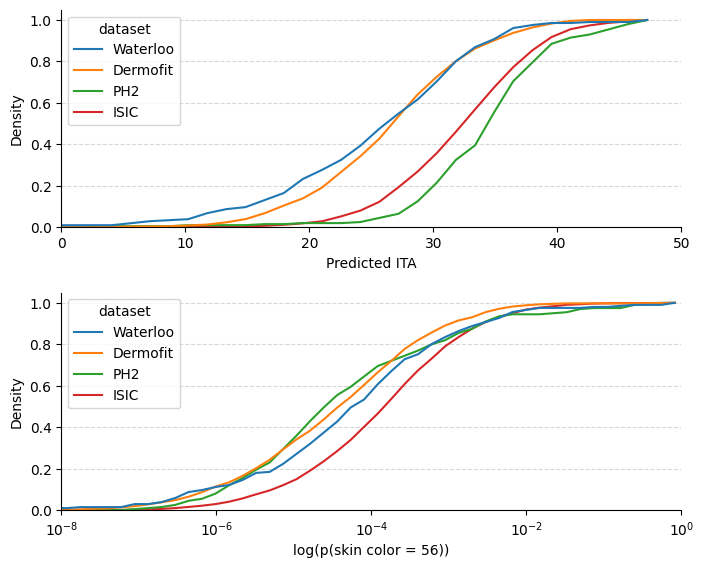

In [11]:
# plot ita angle for each dataset

dataset_names = ['dermis', 'dermquest', 'dermofit', 'ph2', 'isic']
skin_type_dfs = [pd.read_csv(f'data/{d}/skin_color_prediction.csv') for d in dataset_names]
for df, name in zip(skin_type_dfs, dataset_names):
    if name == 'dermis' or name == 'dermquest':
        name = 'Waterloo'
    if name == 'dermofit':
        name = 'Dermofit'
    if name == 'ph2':
        name = 'PH2'
    if name == 'isic':
        name = 'ISIC'
    df['dataset'] = name
skin_type_df = pd.concat(skin_type_dfs)

skin_type_df.rename(columns={
    'ita_angle': 'Predicted ITA',
    'f0_c2': 'log(p(skin color = 56))',
}, inplace=True)

fig, axs = plt.subplots(2, 1, figsize=(8, 6.5))
axs = axs.flatten()

sns.histplot(data=skin_type_df, x='Predicted ITA', hue='dataset', bins=50, common_norm=False, stat='density', cumulative=True, element='poly', fill=False, ax=axs[0])
axs[0].set_xlim(0, 50)

sns.histplot(data=skin_type_df, x='log(p(skin color = 56))', hue='dataset', bins=50, log_scale=True, common_norm=False, stat='density', cumulative=True, element='poly', fill=False, ax=axs[1])
axs[1].set_xlim(10e-9, 1)

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.subplots_adjust(hspace=0.3)
plt.savefig('figures/ita_angle.png', bbox_inches='tight', dpi=300)

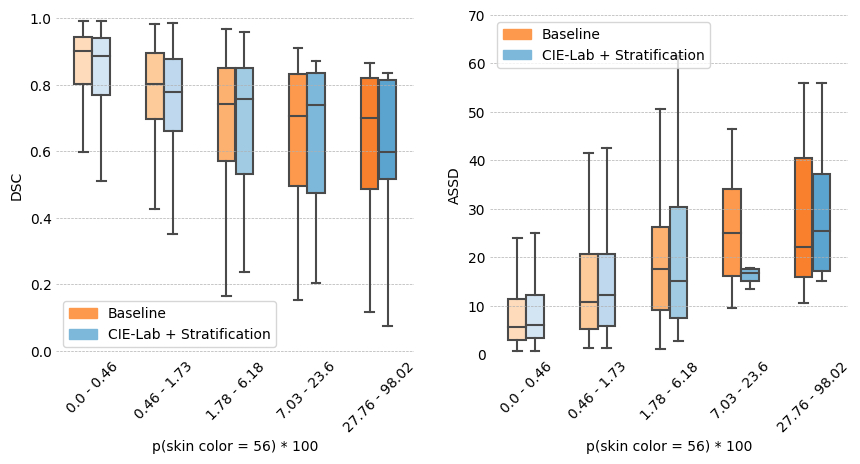

In [12]:
import matplotlib

df1 = df_oos_no_strat.copy()
df1['model'] = 'Baseline'
df2 = df_oos_lab.copy()
df2['model'] = 'CIE-Lab + Stratification'

dfs = [df1, df2]

for df_plot in dfs:
    c2s = df_plot[['f0_c2', 'f1_c2', 'f2_c2', 'f3_c2']].mean(axis=1)
    c1s = df_plot[['f0_c1', 'f1_c1', 'f2_c1', 'f3_c1']].mean(axis=1)
    c0s = df_plot[['f0_c0', 'f1_c0', 'f2_c0', 'f3_c0']].mean(axis=1)

    # binned
    df_plot['c2s'] = c2s
    df_plot['p_bin'] = pd.cut(np.log(c2s), bins=10, labels=False)
    bin_means = df_plot.groupby('p_bin')['c2s'].mean()
    df_plot['p_bin'] = df_plot['p_bin'].apply(lambda x: bin_means[x].round(2))
    bin_max = df_plot.groupby('p_bin')['c2s'].max()
    bin_min = df_plot.groupby('p_bin')['c2s'].min()
    df_plot['range'] = df_plot['p_bin'].apply(lambda x: f'{(bin_min[x] * 100).round(2)} - {(bin_max[x] * 100).round(2)}')

    df_plot['ita'] = pd.cut(df['ita_angle'], bins=4, labels=False)
    bin_means = df_plot.groupby('ita')['ita_angle'].mean()
    df_plot['ita'] = df_plot['ita'].apply(lambda x: bin_means[x].round(0))

df_plot = pd.concat(dfs)

fig, axs = plt.subplots(1, 2, figsize=(9, 5))
axs = axs.flatten()
    

sorting = df_plot.groupby('range')['p_bin'].mean().sort_values().index

sns.boxplot(data=df_plot, x='range', y='dsc', palette='Oranges', fliersize=0, width=0.5, ax=axs[0], hue='model', order=sorting)
axs[0].set_xlabel('p(skin color = 56) * 100')
axs[0].set_ylabel('DSC')
for tick in axs[0].get_xticklabels():
    tick.set_rotation(45)

sns.boxplot(data=df_plot, x='range', y='assd', palette='Oranges', fliersize=0, width=0.5, ax=axs[1], hue='model', order=sorting)
axs[1].set_xlabel('p(skin color = 56) * 100')
axs[1].set_ylabel('ASSD')
for tick in axs[1].get_xticklabels():
    tick.set_rotation(45)

for ax in axs:
    boxes = [c for c in ax.get_children() if isinstance(c, matplotlib.patches.PathPatch)]
    colors_1 = sns.color_palette('Oranges', n_colors=10)[1:]
    colors_2 = sns.color_palette('Blues', n_colors=10)[1:]
    for i, box in enumerate(boxes[0::2]):
        box.set_facecolor(colors_1[i])
    for i, box in enumerate(boxes[1::2]):
        box.set_facecolor(colors_2[i])

# redo the legend
legend_colors = [matplotlib.patches.Patch(color=c) for c in [colors_1[3], colors_2[3]]]
axs[0].legend(legend_colors, ['Baseline', 'CIE-Lab + Stratification'], loc='lower left')
axs[1].legend(legend_colors, ['Baseline', 'CIE-Lab + Stratification'], loc='upper left')

axs[0].set_ylim(-0.01, 1.01)
axs[1].set_ylim(-0.01, 70.01)

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    ax.yaxis.set_tick_params(length=0)
    ax.grid(axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout(pad=2)
plt.savefig('figures/boxplot.png', bbox_inches='tight', dpi=300)

In [13]:
def manual_ttest(df):
    files_56_manual = ['isic_56_manual.txt', 'dermis_56_manual.txt', 'dermquest_56_manual.txt', 'dermofit_56_manual.txt', 'ph2_56_manual.txt']
    names_56_manual = []
    for file in files_56_manual:
        with open('data/' + file, 'r') as f:
            names_56_manual += f.read().splitlines()

    names_56_manual = [n.replace('.jpg', '') for n in names_56_manual]
    metrics_56 = df[df['subject'].isin(names_56_manual)]
    metrics_rest = df[~df['subject'].isin(names_56_manual)]

    print('56 vs rest')
    print('56', metrics_56['dsc'].mean(), metrics_56['dsc'].std(), len(metrics_56))
    print('rest', metrics_rest['dsc'].mean(), metrics_rest['dsc'].std(), len(metrics_rest))
    print(ttest_ind(np.log(1 - metrics_56['dsc']), np.log(1 - metrics_rest['dsc']), equal_var=False, permutations=10000, alternative='greater'))

print('out of sample')
manual_ttest(df_oos_no_strat)

print('oos correct')
manual_ttest(df_oos_lab)

print('in sample')
manual_ttest(df_no_strat)

print('in sample correct')
manual_ttest(df_lab)

out of sample
56 vs rest
56 0.749580052522213 0.2227662996851994 23
rest 0.8361515663425186 0.1562055923480356 1735
Ttest_indResult(statistic=2.139793411016482, pvalue=0.02)
oos correct
56 vs rest
56 0.7261191322213909 0.24120748634207748 23
rest 0.8166286916441658 0.16914943734178167 1735
Ttest_indResult(statistic=2.1320840718745964, pvalue=0.0255)
in sample
56 vs rest
56 0.8378362707463576 0.22059456079646808 23
rest 0.9015690547532514 0.09278120689595667 1735
Ttest_indResult(statistic=1.3091741564076256, pvalue=0.0994)
in sample correct
56 vs rest
56 0.8504477215290573 0.1770828472072867 23
rest 0.9005461882585091 0.09342008434085562 1735
Ttest_indResult(statistic=1.3132688343813486, pvalue=0.0941)


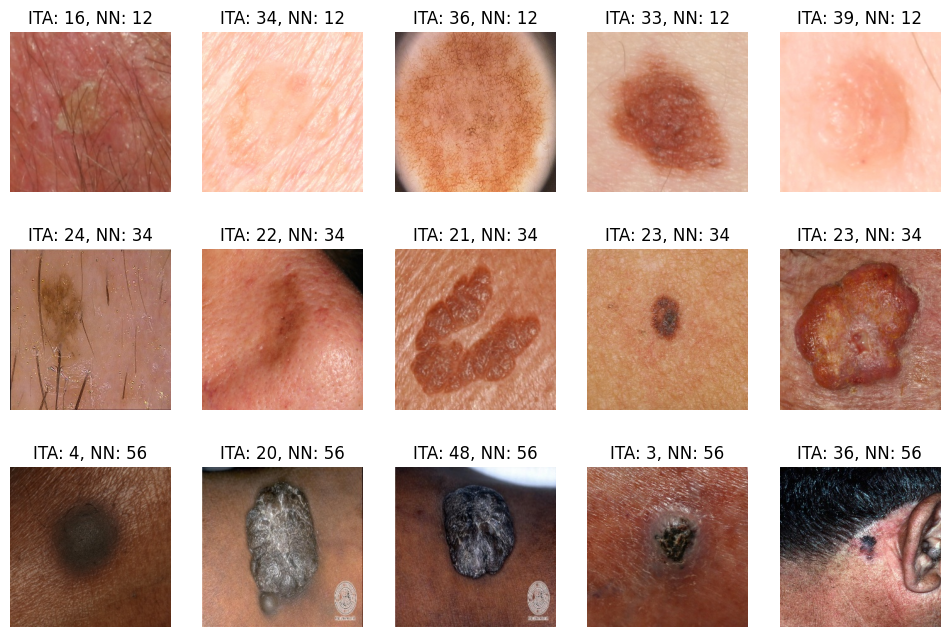

In [16]:
skin_color_analysis_df = df_oos_lab.copy()

rows_56 = skin_color_analysis_df[skin_color_analysis_df['nn_skin_type'] == 56]
rows_34 = skin_color_analysis_df[skin_color_analysis_df['nn_skin_type'] == 34]
rows_12 = skin_color_analysis_df[skin_color_analysis_df['nn_skin_type'] == 12]

np.random.seed(2022)
sample = pd.concat([rows_12.sample(n=5), rows_34.sample(n=5), rows_56.sample(n=5)])

fig, axs = plt.subplots(3, 5, figsize=(12, 8))
axs = axs.flatten()

for i in range(3 * 5):
    row = sample.iloc[i]
    file_name = get_file_name_for_row(row)
    img = cv.imread(file_name)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    axs[i].imshow(img)
    axs[i].set_title(f'ITA: {row["ita_angle"]:.0f}, NN: {row["nn_skin_type"]}')
    axs[i].axis('off')

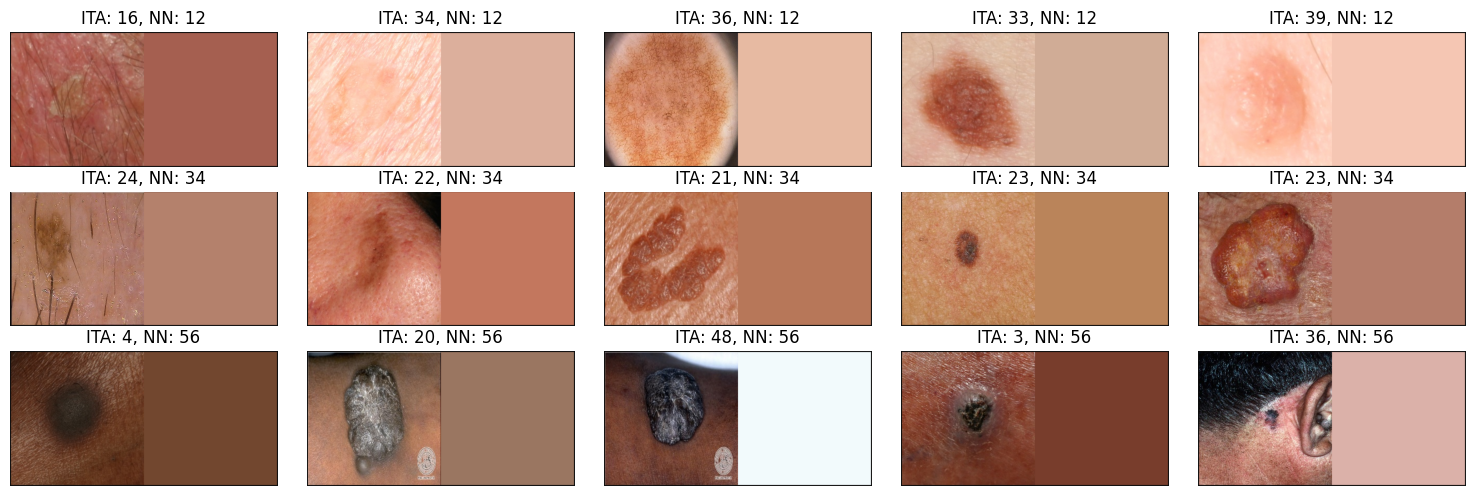

In [17]:
fig, axs = plt.subplots(3, 5, figsize=(15, 5))
axs = axs.flatten()

for i in range(5 * 3):
    row = sample.iloc[i]
    file_name = get_file_name_for_row(row)
    img = cv.imread(file_name)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    kmeans_color = row[['color_r', 'color_g', 'color_b']].values.astype(np.uint8).reshape(1, 1, 3)
    color_img = np.ones(img.shape, dtype=np.uint8) * kmeans_color
    plot_img = np.concatenate([img, color_img], axis=1)
    # add border to img
    plot_img = cv.copyMakeBorder(plot_img, 2, 2, 2, 2, cv.BORDER_CONSTANT, value=[15, 15, 15])
    axs[i].imshow(plot_img)
    axs[i].set_title(f'ITA: {row["ita_angle"]:.0f}, NN: {row["nn_skin_type"]}')
    axs[i].axis('off')

plt.tight_layout()
plt.savefig('figures/skin_prediction_examples.png', dpi=300)

<Axes: xlabel='ita_angle', ylabel='p_56'>

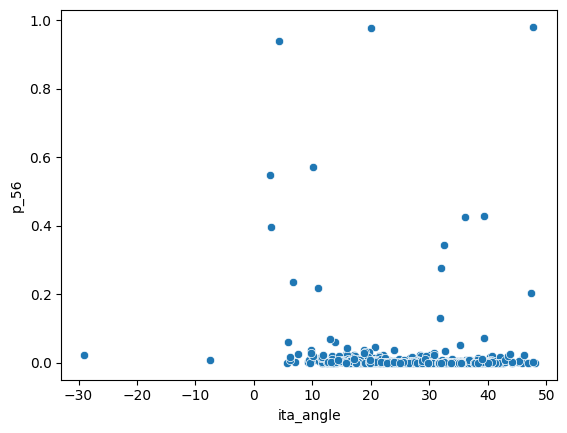

In [24]:
skin_color_analysis_df['p_56'] = skin_color_analysis_df[['f0_c2', 'f1_c2', 'f2_c2', 'f3_c2']].mean(axis=1)
colors = skin_color_analysis_df[['color_r', 'color_g', 'color_b']].values.astype(np.uint8)
colors = colors.reshape(-1, 1, 3)

# scatter plot p_56 vs ita_angle, color by color
plt.scatter